<a href="https://colab.research.google.com/github/alibagheribardi/Regression/blob/main/Diabete_regression_modification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.datasets import load_diabetes
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
diabetes = load_diabetes()
X_diabetes = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
y_continuous = diabetes.target
diabetes_features = diabetes.feature_names

# --- Classification function ---
def classify_target(val):
    if val < 100:
        return 'Very Low'
    elif 100 <= val <= 150:
        return 'Low'
    elif 151 <= val <= 225:
        return 'Moderate'
    else:
        return 'High'

# Apply classification
y_class = pd.Series(y_continuous).apply(classify_target).values
class_labels = np.unique(y_class)

# Initialize dictionaries
tv_diabetes = {}      # Total block count
r2_diabetes = {}
accu_diabetes = {}
label_blocks = {}

# Models
k_opt = 5
knn_reg = KNeighborsRegressor(n_neighbors=k_opt)
knn_cls = KNeighborsClassifier(n_neighbors=k_opt)

for feature in diabetes_features:
    X_feature = X_diabetes[[feature]]

    # Fit regressors
    knn_reg.fit(X_feature, y_continuous)
    r2 = knn_reg.score(X_feature, y_continuous)
    r2_diabetes[feature] = r2

    # Fit classifiers (using custom classes)
    knn_cls.fit(X_feature, y_class)
    predictions = knn_cls.predict(X_feature)
    accuracy = accuracy_score(y_class, predictions)
    accu_diabetes[feature] = accuracy

    # Compute block counts after sorting
    sorted_index = np.argsort(X_feature.values.ravel())
    sorted_labels = y_class[sorted_index]

    block_counts = {}
    for label in class_labels:
        label_mask = (sorted_labels == label).astype(int)
        transitions = np.diff(np.pad(label_mask, (1, 0))) == 1
        block_count = np.sum(transitions)
        block_counts[label] = block_count

    tv_diabetes[feature] = sum(block_counts.values())
    label_blocks[feature] = block_counts

# --- Print sorted results ---
print(f"There are {len(y_class)} datapoints. k_opt={k_opt}")
print(f"{'Feature':30s} | {'TV (Blocks)':^12} | {'R²':^8} | {'Accuracy':^8} | Label Blocks")
print("-" * 95)

for f in sorted(tv_diabetes, key=tv_diabetes.get):
    blocks = label_blocks[f]
    block_str = " | ".join(f"{l}:{blocks[l]}" for l in class_labels)
    print(f"{f:30s} | {tv_diabetes[f]:^12d} | {r2_diabetes[f]:8.2f} | {accu_diabetes[f]:8.2f} | {block_str}")


There are 442 datapoints. k_opt=5
Feature                        | TV (Blocks)  |    R²    | Accuracy | Label Blocks
-----------------------------------------------------------------------------------------------
bmi                            |     284      |     0.48 |     0.54 | High:51 | Low:65 | Moderate:82 | Very Low:86
s5                             |     289      |     0.44 |     0.54 | High:60 | Low:72 | Moderate:81 | Very Low:76
s6                             |     304      |     0.18 |     0.45 | High:64 | Low:78 | Moderate:79 | Very Low:83
s4                             |     306      |     0.13 |     0.35 | High:69 | Low:75 | Moderate:77 | Very Low:85
s3                             |     308      |     0.17 |     0.48 | High:73 | Low:77 | Moderate:72 | Very Low:86
bp                             |     312      |     0.27 |     0.44 | High:64 | Low:76 | Moderate:84 | Very Low:88
s1                             |     314      |     0.20 |     0.51 | High:70 | Low:77 | Moderate

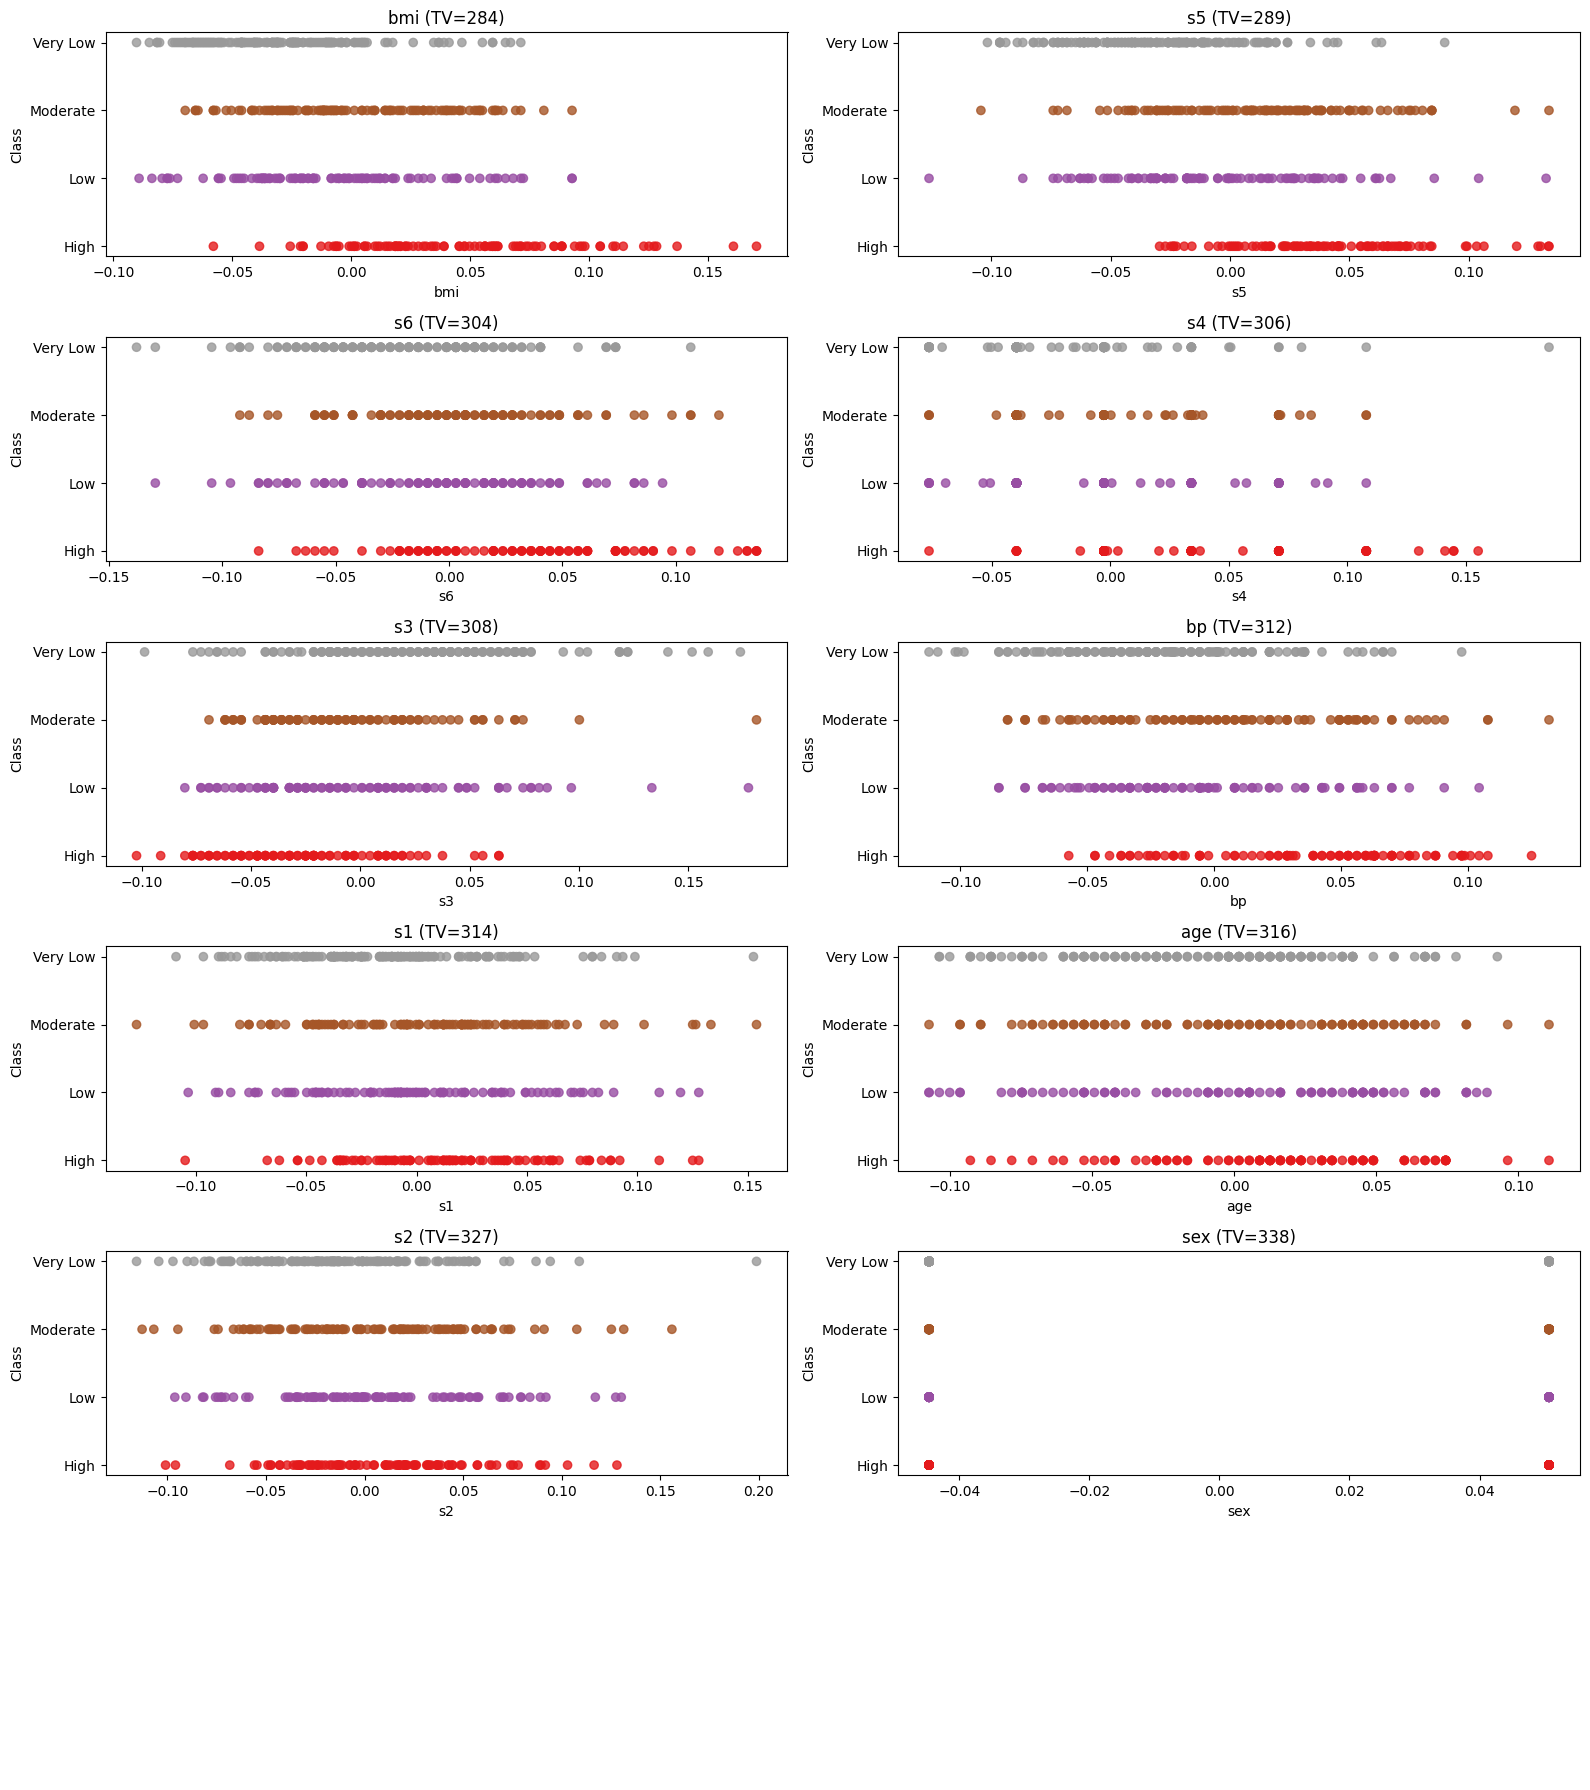

In [2]:
import matplotlib.pyplot as plt

# Sort features by total label block count (TV)
sorted_features = sorted(tv_diabetes, key=tv_diabetes.get)

# Plot
fig, axes = plt.subplots(6, 2, figsize=(16, 18))  # 10 features → 6x2 grid
axes = axes.flatten()

for i, feature in enumerate(sorted_features):
    X_feature = X_diabetes[[feature]]
    sorted_index = np.argsort(X_feature.values.ravel())

    x_vals = X_feature.values.ravel()[sorted_index]
    y_vals = pd.Categorical(y_class[sorted_index], categories=class_labels).codes  # numeric for color

    axes[i].scatter(x_vals, y_vals, c=y_vals, cmap='Set1', alpha=0.8)
    axes[i].set_title(f"{feature} (TV={tv_diabetes[feature]:.0f})")
    axes[i].set_xlabel(feature)
    axes[i].set_yticks(range(len(class_labels)))
    axes[i].set_yticklabels(class_labels)
    axes[i].set_ylabel("Class")

# Hide unused subplots
for j in range(len(diabetes_features), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()
